<a href="https://colab.research.google.com/github/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/module04_02_CNN_training_with_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks Training

## Introduction

Today we will discuss functions we need to override to create a convolutional neural network class based on our `NeuralNetworkClassifier` class.  This will be limited to a single convolutional layer. Let's name the new class `NeuralNetworkClassifierCNN`.  We also assume samples are two-dimensional arrays, like images, with the same number of rows and columns.

We will also introduce how to work with convolutional neural networks in Pytorch, with multiple convolutional layers.

## `NeuralNetworkClassifierCNN`

### `__init__`

The constructor for `NeuralNetworkClassifierCNN` needs two more arguments, in addition to the usual ones:

- `n_inputs`: (int) number of components (columns of X) in each sample.
- `n_hiddens_per_layer`: (list of ints) First int is number of units in the single convolutional layer.
- `n_outputs`: (int) number of outputs, which equals the number of different classes.
- `patch_size`: (int) number of rows (equals number of columns) in size of patches. Often called the kernel size.
- `stride`: (int) number of pixels to shift right and down to produce next patch.
- `activation_function='tanh'`: ('tanh' or 'relu')

To make the right number of weights, we must deal with the convolutional layer first.

```python
      # Initialize weights, by first building list of all weight matrix shapes.
      n_in = n_inputs
      shapes = []
      # First build shape of weight matrix for convolutional layer.  Only one allowed.
      shapes = [(self.patch_size * self.patch_size + 1, n_hiddens_per_layer[0])]
      input_size = int(np.sqrt(n_inputs))
      n_in = ((input_size - self.patch_size) // self.stride + 1) ** 2 * self.n_hiddens_per_layer[0]
      for nh in self.n_hiddens_per_layer[1:]:
          shapes.append((n_in + 1, nh))
          n_in = nh
      shapes.append((n_in + 1, self.n_outputs))
```

### `_make_patches`
We need a new function to convert an input matrix `X` into patches as discussed previously.
```python
   def _make_patches(self, X, patch_size, stride=2):
       '''X: n_samples x n_pixels  (flattened square images)'''

       X = np.ascontiguousarray(X)  # make sure X values are contiguous in memory

       n_samples = X.shape[0]
       image_size = int(np.sqrt(X.shape[1]))
       n_patches = (image_size - patch_size ) // stride + 1
       nb = X.itemsize  # number of bytes each value
       new_shape = [n_samples, n_patches, n_patches, patch_size, patch_size]
       new_strides = [image_size * image_size * nb,
                      image_size * stride * nb,
                      stride * nb,
                      image_size * nb,
                      nb]
       X = np.lib.stride_tricks.as_strided(X, shape=new_shape, strides=new_strides)
       X = X.reshape(n_samples, n_patches * n_patches, patch_size * patch_size)

       return X
```

## `use`
Now that we have `_make_patches` we know how to modify our `use` function.
```python
   def use(self, X):
       '''X assumed to not be standardized. Returns (classes, class_probabilities)'''
       # Standardize X
       X = (X - self.Xmeans) / self.Xstds
       # Convert flattened samples into patches
       X_patches = self._make_patches(X, self.patch_size, self.stride)
       Ys = self.forward_pass(X_patches)
       Y = self.softmax(Ys[-1])
       classes = self.classes[np.argmax(Y, axis=1)].reshape(-1, 1)
       return classes, Y
```

### `forward_pass`
As you see, `forward_pass` has to be modified a bit to handle input as patches.  It also must flatten the image obtained as output of the convolutional layer for use as input to the following fully-connected layer.
```python
   def forward_pass(self, X_patches):
       '''X assumed already standardized. Output returned as standardized.'''
       self.Ys = [X_patches]
       for layer_i, W in enumerate(self.Ws[:-1]):
           if self.activation_function == 'relu':
               self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
           else:
               self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
           # If convolutional layer, flatten each sample into vector for input to following f
           # fully-connected layer.
           if layer_i == 0:
               self.Ys[-1] = self.Ys[-1].reshape(self.Ys[-1].shape[0], -1)
       last_W = self.Ws[-1]
       self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
       return self.Ys
```

### `train`
The only change needed in `train` is to create patches from `X`
```python
        X_patches = self._make_patches(X, self.patch_size, self.stride)
```
and use this form of `X` as input matrix for optimizer calls, such as
```python
           error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                       fargs=[X_patches, T_indicator_vars], n_epochs=n_epochs,
                                       learning_rate=learning_rate,
                                       verbose=verbose,
                                       error_convert_f=error_convert_f)
```

###  `error_f`
What must we change for `error_f`?

Nothing!  Yay!

### `gradient_f`
However, we do have to do a little work for `gradient_f`.  This is the trickiest part of our convolutional neural network. But, remember, once we move to `pytorch`, we do not have to write this function!

To the back-propagation loop that steps backwards through the layers we add a special case when we have reached the first layer.
```python
        for layeri in range(n_layers - 1, -1, -1):
            if layeri == 0:
                # Convolutional layer
                # delta, backpropagated from a fully-connected layer, has multiple values for each
                # convolutional unit, for each application of it to each patch.  We must sum the dE_dWs
                # for all of those delta values by multiplying each delta value for each convolutional
                # unit by the patch values used to produce the output by the input values for the
                # corresponding patch.
                # Do this by first reshaping the backed-up delta matrix to the right form.
                patch_n_values = X_patches.shape[-1]
                n_conv_units = self.n_hiddens_per_layer[0]
                delta_reshaped = delta.reshape(-1, n_conv_units)
                # And we must reshape the convolutional layer input matrix to a compatible shape.
                conv_layer_inputs_reshaped = self.Ys[0].reshape(-1, patch_n_values)
                # Now we can calculate the dE_dWs for the convolutional layer with a simple matrix
                # multiplication.
                self.dE_dWs[layeri][1:, :] = conv_layer_inputs_reshaped.T @ delta_reshaped
                self.dE_dWs[layeri][0:1, :] = np.sum(delta_reshaped, axis=0)
            else:
                # Fully-connected layers
                . . .
```

## Example use of `NeuralNetworkClassifierCNN`

After you define `NeuralNetworkClassifierCNN` as a new class that extends `NeuralNetworkClassifier`, you can use it as in the following example.

Let's make some simple images that are either squares or diamond shapes, like this.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
square = np.array([[0] * 20,
                   [0] * 20,
                   [0] * 20,
                   [0] * 20,
                   [0] * 4 + [1] * 12 + [0] * 4,
                   [0] * 4 + [1] + [0] * 10 + [1] + [0] * 4,
                   [0] * 4 + [1] + [0] * 10 + [1] + [0] * 4,
                   [0] * 4 + [1] + [0] * 10 + [1] + [0] * 4,
                   [0] * 4 + [1] + [0] * 10 + [1] + [0] * 4,
                   [0] * 4 + [1] + [0] * 10 + [1] + [0] * 4,
                   [0] * 4 + [1] + [0] * 10 + [1] + [0] * 4,
                   [0] * 4 + [1] + [0] * 10 + [1] + [0] * 4,
                   [0] * 4 + [1] + [0] * 10 + [1] + [0] * 4,
                   [0] * 4 + [1] + [0] * 10 + [1] + [0] * 4,
                   [0] * 4 + [1] + [0] * 10 + [1] + [0] * 4,
                   [0] * 4 + [1] * 12 + [0] * 4,
                   [0] * 20,
                   [0] * 20,
                   [0] * 20,
                   [0] * 20])
square

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
    diamond = np.array([[0] * 20,
                        [0] * 20,
                        [0] * 20,
                        [0] * 20,
                        [0] * 9 + [1] + [0] * 10,
                        [0] * 8 + [1, 0, 1] + [0] * 9,
                        [0] * 7 + [1, 0, 0, 0, 1] + [0] * 8,
                        [0] * 6 + [1, 0, 0, 0, 0, 0, 1] + [0] * 7,
                        [0] * 5 + [1, 0, 0, 0, 0, 0, 0, 0, 1] + [0] * 6,
                        [0] * 4 + [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] + [0] * 5,
                        [0] * 3 + [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] + [0] * 4,
                        [0] * 4 + [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] + [0] * 5,
                        [0] * 5 + [1, 0, 0, 0, 0, 0, 0, 0, 1] + [0] * 6,
                        [0] * 6 + [1, 0, 0, 0, 0, 0, 1] + [0] * 7,
                        [0] * 7 + [1, 0, 0, 0, 1] + [0] * 8,
                        [0] * 8 + [1, 0, 1] + [0] * 9,
                        [0] * 9 + [1] + [0] * 10,
                        [0] * 20,
                        [0] * 20,
                        [0] * 20])
diamond

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0,

In [ ]:
def draw_neg_image(image, label=''):
    plt.imshow(-image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(label)

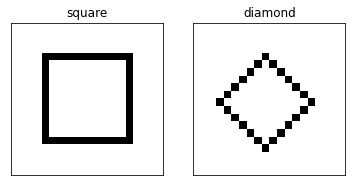

In [ ]:
plt.subplot(1, 2, 1)
draw_neg_image(square, 'square')
plt.subplot(1, 2, 2)
draw_neg_image(diamond, 'diamond');

Okay, that works.  Let's write a function to generate a bunch of images like these, but shifted left to right and up and down to random amounts.  This would challenge our fully-connected nets, but maybe not our convolutional net!

In [ ]:
def make_images(n_each_class):
    '''Make 20x20 black and white images with diamonds or squares for the two classes, as line drawings.'''
    images = np.zeros((n_each_class * 2, 20, 20))  # nSamples, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(n_each_class * 2, 1))
    centers = np.zeros((n_each_class * 2, 2))
    for i in range(n_each_class * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < n_each_class:
            # squares
            images[i, x - r:x + r, y + r] = 1.0
            images[i, x - r:x + r, y - r] = 1.0
            images[i, x - r, y - r:y + r] = 1.0
            images[i, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, range(x - r, x), range(y, y + r)] = 1.0
            images[i, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, range(x, x + r), range(y - r, y)] = 1.0
    T = np.array(['square'] * n_each_class + ['diamond'] * n_each_class).reshape(-1, 1)
    return images, T

In [ ]:
n_each_class = 100
Xtrain, Ttrain = make_images(n_each_class)
Xtest, Ttest = make_images(n_each_class)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((200, 20, 20), (200, 1), (200, 20, 20), (200, 1))

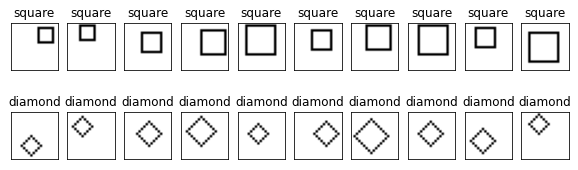

In [ ]:
plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    draw_neg_image(Xtrain[i, :], Ttrain[i, 0])

for i in range(10):
    plt.subplot(2, 10, i + 11)
    draw_neg_image(Xtrain[i + n_each_class, :], Ttrain[i + n_each_class, 0])

In [ ]:
import neuralnetworks_A5 as nn

Now we can try to train a CNN!!
Our net has been defined to accept two-dimensional input `X` matrices, so first we must flatten each image.

In [ ]:
Ttrain[:10, 0]

array(['square', 'square', 'square', 'square', 'square', 'square',
       'square', 'square', 'square', 'square'], dtype='<U7')

In [ ]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], -1)
Xtest = Xtest.reshape(Xtest.shape[0], -1)
Xtrain.shape, Xtest.shape

((200, 400), (200, 400))

Let's try 2 units in the convolutional layer followed by one fully-connected layer of 2 units.  And let's use a patch size of 5 and stride of 2.

In [ ]:
np.unique(Ttrain)

array(['diamond', 'square'], dtype='<U7')

In [ ]:
import time
import neuralnetworks_A5 as nn

In [ ]:
nnet = nn.NeuralNetworkClassifierCNN(Xtrain.shape[1], [2], len(np.unique(Ttrain)),
                                       patch_size=5, stride=2)
start_time = time.time()
nnet.train(Xtrain, Ttrain, 2000, learning_rate=0.01, method='adam')
classes_train, probs_train = nnet.use(Xtrain)

print(f'took {time.time() - start_time} seconds')
print(f'Train percent correct {100 * np.mean(Ttrain == classes_train)}')

classes_test, probs_test = nnet.use(Xtest)
print(f'Test fraction correct {100 * np.mean(Ttest == classes_test)}')

Adam: Epoch 200 Error=0.99948
Adam: Epoch 400 Error=0.99984
Adam: Epoch 600 Error=0.99992
Adam: Epoch 800 Error=0.99995
Adam: Epoch 1000 Error=0.99996
Adam: Epoch 1200 Error=0.99997
Adam: Epoch 1400 Error=0.99998
Adam: Epoch 1600 Error=0.99998
Adam: Epoch 1800 Error=0.99999
Adam: Epoch 2000 Error=0.99999
took 2.904790163040161 seconds
Train percent correct 100.0
Test fraction correct 100.0


In [ ]:
np.unique(Ttrain)

array(['diamond', 'square'], dtype='<U7')

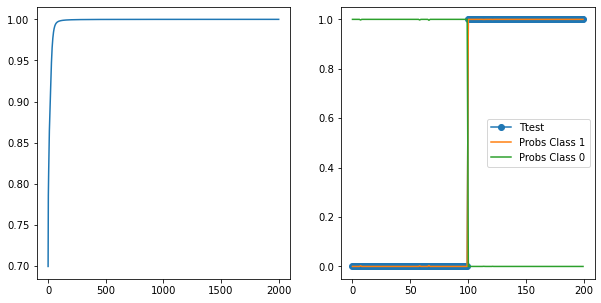

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)

Ttest_i = (Ttest == 'diamond').astype(int)

plt.subplot(1, 2, 2)
plt.plot(Ttest_i, 'o-')
plt.plot(probs_test[:, :], '-')
plt.legend(('Ttest', 'Probs Class 1', 'Probs Class 0'));

Cool.  Let's see what our two convolutional units learned.  Draw images of their weight matrices.

In [ ]:
#number of pixels in each patch
#5 x 5 patch + 1 bias weight
nnet.Ws[0].shape

(26, 2)

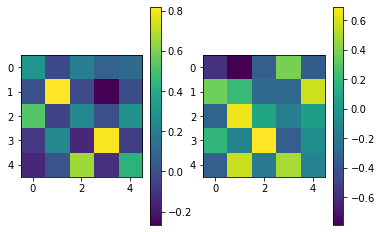

In [ ]:
conv_W = nnet.Ws[0][1:, :]  # do not include bias weights

plt.subplot(1, 2, 1)
plt.imshow(conv_W[:, 0].reshape(5, 5)) # first unit
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(conv_W[:, 1].reshape(5, 5)) # second unit
plt.colorbar()

In [ ]:
conv_W[:, 0].reshape(5, 5) # print the first unit

array([[ 0.29863189, -0.02124669,  0.19698273,  0.07529536,  0.11743154],
       [ 0.00464144,  0.81641365, -0.0202866 , -0.26617104, -0.0072444 ],
       [ 0.52531431, -0.04334969,  0.23491773, -0.00193867,  0.28027161],
       [-0.08749799,  0.23339155, -0.14083358,  0.80734466, -0.06664136],
       [-0.14296563,  0.01440076,  0.66347136, -0.12129824,  0.43165675]])

So, each hidden unit contains a 5 x 5 filter.  The colors represent the value of that value in the matrix.  Unlike the last lecture where we defined a filter to detect a very specific image feature (a specific kind of edge), these units have been trained with filters to detect both squares and diamonds, at arbitrary locations in the image.  They do pretty well at it!  But you'll notice that the filters doesn't visibly resemble either square features or diamond features, really.

Let's imagine, if we trained a CNN to detect dogs, would you expect the filters in that network to visibly resemble "dog" features?

<span style="color:white">No</span>

Let's repeat, with 4 convolutional units and with two fully-connected layers after the convolutional layer.

In [ ]:
nnet = nn.NeuralNetworkClassifierCNN(Xtrain.shape[1], [4, 10, 10], len(np.unique(Ttrain)),
                                       patch_size=5, stride=2)

start_time = time.time()
nnet.train(Xtrain, Ttrain, 1000, learning_rate=0.01, verbose=True, method='adam') # training for 1K epochs instead of 2K
classes_train, probs_train = nnet.use(Xtrain)

print(f'took {time.time() - start_time} seconds')
print(f'Train percent correct {100 * np.mean(Ttrain == classes_train)}')

classes_test, probs_test = nnet.use(Xtest)
print(f'Test fraction correct {100 * np.mean(Ttest == classes_test)}')

Adam: Epoch 100 Error=0.99794
Adam: Epoch 200 Error=0.99932
Adam: Epoch 300 Error=0.99963
Adam: Epoch 400 Error=0.99976
Adam: Epoch 500 Error=0.99983
Adam: Epoch 600 Error=0.99987
Adam: Epoch 700 Error=0.99990
Adam: Epoch 800 Error=0.99992
Adam: Epoch 900 Error=0.99993
Adam: Epoch 1000 Error=0.99994
took 2.1891582012176514 seconds
Train percent correct 100.0
Test fraction correct 100.0


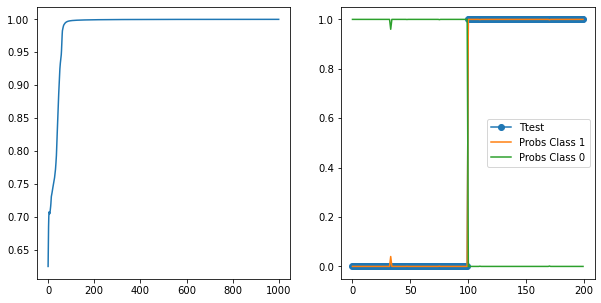

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)

Ttest_i = (Ttest == 'diamond').astype(int)

plt.subplot(1, 2, 2)
plt.plot(Ttest_i, 'o-')
plt.plot(probs_test[:, :], '-')
plt.legend(('Ttest', 'Probs Class 1', 'Probs Class 0'))

Training converges faster, but the generalization to test data not as accurate.

Let's see what our four convolutional units learned.  Draw images of their weight matrices.

In [ ]:
nnet.Ws[0].shape

(26, 4)

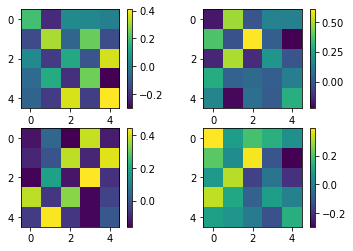

In [ ]:
conv_W = nnet.Ws[0][1:, :]  # do not include bias weights

for uniti in range(4):
    plt.subplot(2, 2, uniti + 1)
    plt.imshow(conv_W[:, uniti].reshape(5, 5))
    plt.colorbar()

How well would a fully-connected, non-convolutional net do?

In [ ]:
Xtrain.shape, Ttrain.shape

((200, 400), (200, 1))

In [ ]:
# nnet = nn. NeuralNetworkClassifierCNN(20 * 20, [4, 2], len(np.unique(Ttrain)),
#                                        patch_size=5, stride=2)

nnet = nn. NeuralNetworkClassifier(Xtrain.shape[1], [4, 2], len(np.unique(Ttrain)))

start_time = time.time()
nnet.train(Xtrain, Ttrain, 1000, learning_rate=0.01, verbose=True, method='adam')
classes_train, probs_train = nnet.use(Xtrain)

print(f'took {time.time() - start_time} seconds')
print(f'Train percent correct {100 * np.mean(Ttrain == classes_train)}')

classes_test, probs_test = nnet.use(Xtest)
print(f'Test fraction correct {100 * np.mean(Ttest == classes_test)}')

Adam: Epoch 100 Error=0.97805
Adam: Epoch 200 Error=0.99140
Adam: Epoch 300 Error=0.99517
Adam: Epoch 400 Error=0.99684
Adam: Epoch 500 Error=0.99774
Adam: Epoch 600 Error=0.99829
Adam: Epoch 700 Error=0.99865
Adam: Epoch 800 Error=0.99891
Adam: Epoch 900 Error=0.99910
Adam: Epoch 1000 Error=0.99924
took 0.8956232070922852 seconds
Train percent correct 100.0
Test fraction correct 86.5


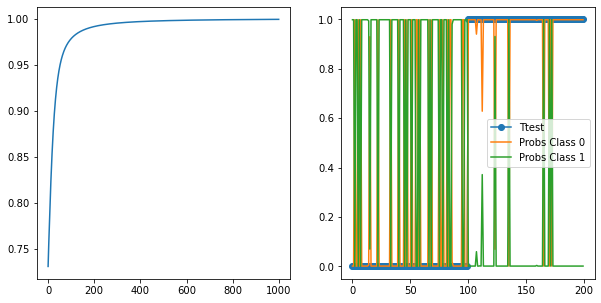

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)

Ttest_i = (Ttest == 'diamond').astype(int)

plt.subplot(1, 2, 2)
plt.plot(Ttest_i, 'o-')
plt.plot(probs_test[:, :], '-')
plt.legend(('Ttest', 'Probs Class 0', 'Probs Class 1'))

In [ ]:
first_layer_W = nnet.Ws[0][1:, :]  # do not include bias weights
print(first_layer_W.shape)

(400, 4)


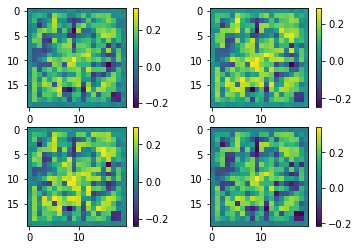

In [ ]:
for uniti in range(4):
    plt.subplot(2, 2, uniti + 1)
    plt.imshow(first_layer_W[:, uniti].reshape(20, 20))  # notice we have to reshape to the full image size
    plt.colorbar()

The fully-connected net tends to overfit to the training data, but fails to perform as well on the testing data.  Look at the 1,600 weights we plotted above (specifically the kinds of shapes you can pick out in there).  What does this tell us about what the fully-connected net is learning?

## Summary

So, to summarize, with fewer weights, convolutional nets can learn more generalizable matrices (filters).  These filters do not necessarily "match" image features (visibly) but can also be trained to recognize multiple types of features at the same time (e.g., squares vs. diamonds, or straight lines vs. diagonal lines).

We need to make our input image into strided, overlapping patches first, so that the filters can learn the differences and similarities between neighboring patches that differ slightly.

After you standardize your input values (remember, these are just numbers, like intensity or color values), you convert that entire matrix into patches.  You do this in both `train` and `use`.

The input to your `forward_pass` function is the patches, not the raw inputs.  If the output of a convolutional layer is input to a fully-connected layer, you must flatten that output into a single vector.

Back-prop is a little tricky.  The delta that is back-propped from a fully-connected layer, has multiple values for each convolutional unit, that come from each application of that unit from each patch.  We must sum $\frac{\partial E}{\partial W}$ for all delta values:
    
1. Reshape the delta matrix to $K \times N$ where $N$ is the number of units in this convolutional layer.
2. Reshape the convolutional layer input matrix to $N \times P$ where $P$ is the number of values in a patch.
3. Multiply the two together to get the gradient of everything but the bias weights.
4. Sum every column of the reshaped delta matrix to get the gradient of the bias weights.
    
Compare to back-propagating through a fully connected layer, where we:

3. Simply multiply the inputs to the layer by the delta.
4. Don't need to reshape the delta matrix.